In [1]:
import pandas as pd
import numpy as np
from database.db_api import db_api
db = db_api()
DATASET = 'all_attacks_spaced'

Setting database to ip: 127.0.0.1, port 3306


In [2]:
def show_msus(msus):
    for msu in msus:
        print "Id: {msu.msu}, Type: {msu.msu_type.name}".format(msu = msu)
msus = db.get_items('msus')
show_msus(msus)

Connected to database
Id: 10, Type: socket
Id: 11, Type: socket
Id: 12, Type: socket
Id: 13, Type: http
Id: 14, Type: http
Id: 15, Type: http
Id: 16, Type: read
Id: 17, Type: read
Id: 18, Type: read
Id: 19, Type: read
Id: 20, Type: read
Id: 21, Type: read
Id: 22, Type: read
Id: 23, Type: read
Id: 24, Type: read
Id: 25, Type: regex
Id: 26, Type: regex
Id: 27, Type: regex
Id: 28, Type: regex
Id: 29, Type: regex
Id: 30, Type: regex
Id: 31, Type: regex_route
Id: 32, Type: regex_route
Id: 33, Type: regex_route
Id: 34, Type: write
Id: 35, Type: write
Id: 36, Type: write


In [3]:
import json
EVENT_TYPES = 'client', 'tls_reneg', 'slowloris', 'redos'
def read_event_log(event_log_file,
                   columns=('time_', 'status_', 'name_')):
    event_log = json.load(open(event_log_file))
    events = pd.DataFrame(event_log, columns=columns)
    events = events.rename(columns={c: c.strip("_") for c in columns})
    events = events[events.name.isin(EVENT_TYPES)]
    events.time *= 1e9
    return events

def get_traffic_times(events):
    start_events = events[events.status == 'start'].sort_values(by='name').reset_index()
    end_events = events[events.status == 'end'].sort_values(by='name').reset_index()
    
    timeframes = pd.concat((start_events.name, 
                            start_events.time.rename("start"), 
                            end_events.time.rename('end')),
                           axis=1).sort_values(by='start')
    return timeframes
    
events = read_event_log('/home/iped/datasets/{ds}/event_log.json'.format(ds=DATASET))
traffic = get_traffic_times(events)
print traffic

        name         start           end
0     client  1.513962e+18  1.513964e+18
1      redos  1.513962e+18  1.513963e+18
5  tls_reneg  1.513963e+18  1.513963e+18
2  slowloris  1.513964e+18  1.513964e+18
3  slowloris  1.513964e+18  1.513964e+18
4  slowloris  1.513964e+18  1.513964e+18


In [4]:
def get_msu(msu_id):
    return [msu for msu in msus if msu.msu == msu_id][0]

def get_msu_type(msu_id):
    return get_msu(msu_id).msu_type.name

def sample_msu_ids_by_type():
    types = set([msu.msu_type.name for msu in msus])
    ids = [[m.msu for m in msus if m.msu_type.name == t][0] for t in types]
    return ids

def res_round(x, resolution):
    return ((x / resolution).round() * resolution).astype(x.dtype)

def get_msu_df(msu):
    print "Getting dataframe for msu {msu.msu} ({msu.msu_type.name})".format(msu=msu)
    df = db.get_msu_full_df(msu)
    trange = (max(df.TIME) - min(df.TIME)) * 1e-9
    spp = round(trange / len(df), 2)
    print "\n # Points: {}\n Time range: {} seconds\n Points / second: ~{}".format(
        len(df), trange, 1/spp)

    rounded_time = res_round(df.TIME, spp * 1e9)

    epoch = ((rounded_time - min(rounded_time)) / (spp * 1e9)).astype(int)
    df = df.assign(msu_id = msu.msu)
    df = df.assign(msu_type = msu.msu_type.name)
    df = df.assign(epoch = epoch)
    df = df.set_index('TIME')
    df = df.assign(TIME = df.index)
    return df    

AGGREGATE_STAT_TYPES = (
 "ERROR_COUNT",
 "MSU_USER_TIME", "MSU_KERNEL_TIME",
 "MSU_MINOR_FAULTS", "MSU_MAJOR_FAULTS",
 "MSU_VOL_CTX_SW","MSU_INVOL_CTX_SW",
)

#MSU_IDS = sample_msu_ids_by_type()
MSU_IDS = [msu.msu for msu in msus] 
    
df = pd.concat([get_msu_df(get_msu(i)) for i in MSU_IDS])


Getting dataframe for msu 10 (socket)
Connected to database
Connected to database

 # Points: 3895
 Time range: 1947.98936133 seconds
 Points / second: ~2.0
Getting dataframe for msu 11 (socket)
Connected to database
Connected to database

 # Points: 3897
 Time range: 1948.23102264 seconds
 Points / second: ~2.0
Getting dataframe for msu 12 (socket)
Connected to database
Connected to database

 # Points: 3886
 Time range: 1942.73992962 seconds
 Points / second: ~2.0
Getting dataframe for msu 13 (http)
Connected to database
Connected to database

 # Points: 3894
 Time range: 1947.98936133 seconds
 Points / second: ~2.0
Getting dataframe for msu 14 (http)
Connected to database
Connected to database

 # Points: 3896
 Time range: 1948.23102264 seconds
 Points / second: ~2.0
Getting dataframe for msu 15 (http)
Connected to database
Connected to database

 # Points: 3885
 Time range: 1942.73992962 seconds
 Points / second: ~2.0
Getting dataframe for msu 16 (read)
Connected to database
Connec

In [5]:
import copy
def make_numeric(df):
    for x in df.columns:
        try:
            df[x] = pd.to_numeric(df[x])
        except:
            pass

def convert_to_rates(df, types=AGGREGATE_STAT_TYPES):
    df_cp = copy.copy(df)
    for t in types:
        df_cp[t] = df[t].diff() / df.TIME.diff()
    return df_cp
print 'making numeric'
make_numeric(df)
print 'converting to rates'
rate_df = convert_to_rates(df)
print 'coverted'

converting to rates
coverted


In [6]:
def average_within_type_epoch(df):
    return df.groupby(['msu_type', 'epoch'], as_index=False).mean().drop('msu_id', 1)

type_df = average_within_type_epoch(rate_df)

In [7]:
def label_with_traffic(df, traffic):
    mask = (df.TIME > min(traffic.start)) & (df.TIME < max(traffic.end))
    
    print "Filtering out {} pre/post-traffic points".format(np.sum(~mask))
    print "{} points remaining".format(np.sum(mask))
    df = df[mask]
    print "Range of time: {} seconds ".format((max(df.TIME) - min(df.TIME))*1e-9)
    
    ordered = traffic.sort_values(by='start')
    df = df.assign(traffic='')
    for i, attack in ordered.iterrows():
        mask = (df.TIME > attack.start) & (df.TIME < attack.end)
        print "Marking %d points as type %s" % (mask.sum(), attack['name'])
        df.loc[(df.TIME > attack.start) & (df.TIME < attack.end), 'traffic'] = attack['name']
    return df

type_df = label_with_traffic(type_df, traffic)


Filtering out 516 pre/post-traffic points
22872 points remaining
Range of time: 1905.47734784 seconds 
Marking 22872 points as type client
Marking 3600 points as type redos
Marking 3600 points as type tls_reneg
Marking 1194 points as type slowloris
Marking 1194 points as type slowloris
Marking 1194 points as type slowloris


In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt

def separate_attacks(df):
    traffic_types = np.unique(df.traffic)
    separated = []
    for traffic in traffic_types:
        if traffic == 'client':
            continue
        traffic_df = df[df.traffic == traffic]
        traffic_start_time = min(traffic_df.TIME)
        traffic_end_time = max(traffic_df.TIME)
        last_traffic = df[(df.TIME < traffic_start_time) & (df.traffic != 'client')]
        if len(last_traffic) == 0:
            last_end = min(df.TIME)
        else:
            last_end = max(last_traffic.TIME)
        
        separated.append(df[(df.TIME > last_end) & (df.TIME < traffic_end_time)])
    return separated

separated = separate_attacks(type_df)


<IPython.core.display.Javascript object>


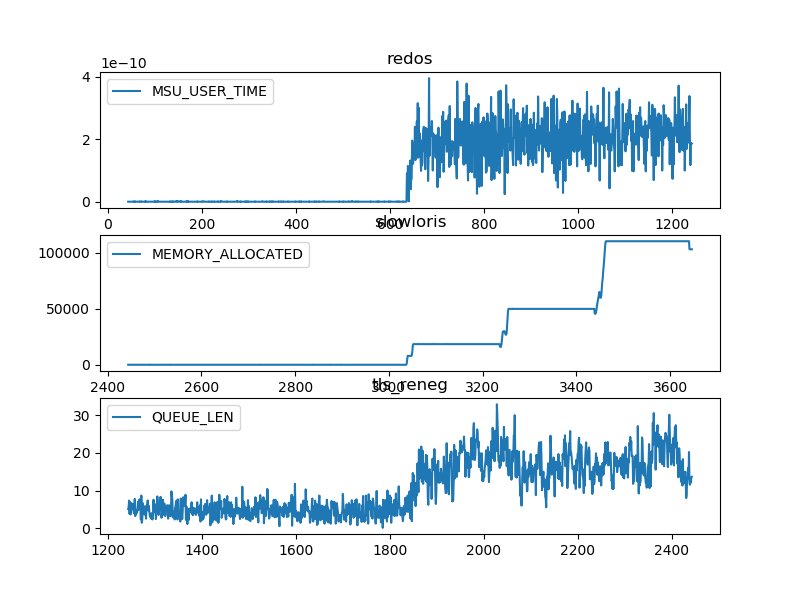

In [18]:
def plot_metric(df, metric, label):
    plt.plot(df.epoch, df[metric], label=metric)
    plt.title(label)
    plt.legend()
    
TRAFFIC_MSUS = dict(
    tls_reneg = 'read',
    redos = 'regex',
    slowloris = 'http'    
)
    
TRAFFIC_METRICS = dict(
    tls_reneg = 'QUEUE_LEN',
    redos = 'MSU_USER_TIME',
    slowloris = 'MEMORY_ALLOCATED'
)    
    
def plot_traffic_metrics(traffic_dfs, metrics=TRAFFIC_METRICS, msus=TRAFFIC_MSUS):
    fig, ax = plt.subplots(len(traffic_dfs), 1, figsize=(8, 6))
    for i, traffic_df in enumerate(traffic_dfs):
        traffic_type = traffic_df.iloc[-1].traffic
        plt.sca(ax[i])
        msu_df = traffic_df[traffic_df.msu_type == msus[traffic_type]]
        plot_metric(msu_df, metrics[traffic_type], traffic_type)
        
plot_traffic_metrics(separated)

<IPython.core.display.Javascript object>


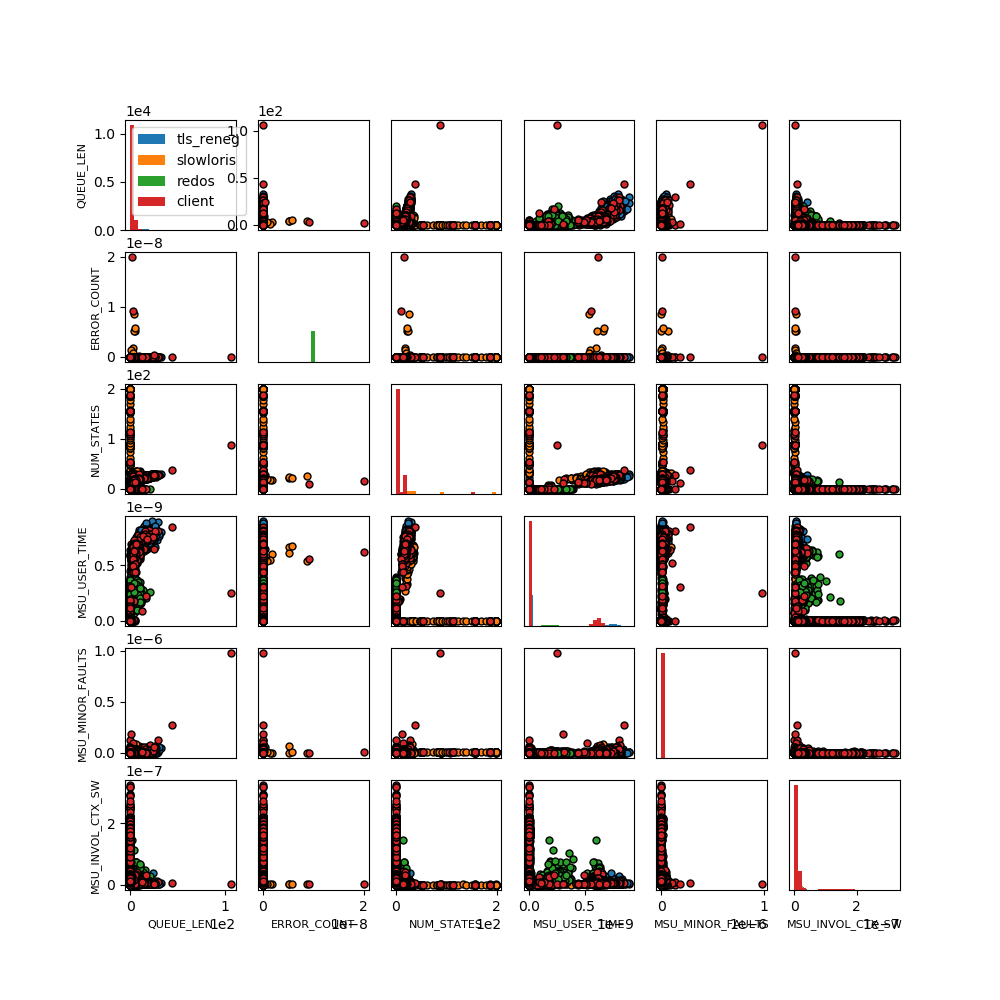

In [20]:
%matplotlib notebook
import matplotlib.pyplot as plt 
def plot_metrics(df, metrics=AGGREGATE_STAT_TYPES, edgecolor='k', markersize=5):
    fig, ax = plt.subplots(len(metrics), len(metrics), figsize=(10,10))
    traffics = pd.unique(df.traffic.sort_values(ascending=False))
    for j, m1 in enumerate(metrics):
        for i, m2 in enumerate(metrics):
            for traffic in traffics:
                group = df[df.traffic == traffic]
                if i != j:
                    ax[i][j].plot(group[m1], group[m2], 'o', markeredgecolor=edgecolor, 
                                  markersize=markersize,label=traffic)
                else:
                    ax[i][j].hist(group[m1], 25, label=traffic)
            ax[i][j].ticklabel_format(style='sci', axis='both', scilimits=(2,2))
            if i == len(metrics)-1:
                ax[i][j].set_xlabel(m1, fontsize=8)
            else:
                ax[i][j].set_xticks([])
            if j == 0:
                ax[i][j].set_ylabel(m2, fontsize=8)
            elif j != 1 or i != 0:
                ax[i][j].set_yticks([])
                    
            if i == 0 and j == 0:
                ax[i][j].legend()
                
    plt.savefig("metrics.png")
PLOTTED_STAT_TYPES = (
 "QUEUE_LEN", "ERROR_COUNT", "NUM_STATES",
 "MSU_USER_TIME", "MSU_MINOR_FAULTS", 
 "MSU_INVOL_CTX_SW",
)        
            
plot_metrics(type_df, PLOTTED_STAT_TYPES)

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

def plot_metrics_3d(df, m1, m2, m3, title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    traffics = pd.unique(df.traffic.sort_values(ascending=False))
    for traffic in traffics:
        group = df[df.traffic == traffic]
        ax.scatter(group[m1], group[m2], group[m3], label=traffic)
    ax.legend()
    ax.set_xlabel(m1)
    ax.set_ylabel(m2)
    ax.set_zlabel(m3)
    if title is not None:
        fig.title(title)
        
metrics = ['MSU_USER_TIME', 'NUM_STATES', 'MSU_INVOL_CTX_SW']
        
#for msu_id in df.msu_id.unique():
#    plot_metrics_3d(df[df.msu_id == msu_id], *metrics)
    
plot_metrics_3d(df, *metrics)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

def combine_msus(df, metrics=None):
    msu_ids = np.unique(df.msu_id)
    cols = df.columns
    if metrics is None:
        stats = cols[(cols != 'TIME') & (cols != 'msu_id') & (cols != 'epoch')]
    else:
        stats = list(metrics) + ['traffic']
            
    tuples = [(mid, st) for mid in msu_ids for st in stats]
    new_cols = ['%s_%d' % (st, mid) for mid, st in tuples]
    new_df = pd.DataFrame(index=df.epoch.unique(), columns=new_cols)
    
    for (mid, st), col in zip(tuples, new_cols):
        msu_vals = df[df.msu_id == mid]
        vals = msu_vals.set_index('epoch')[[st]]
        new_df[[col]] = vals
    
    return new_df[~new_df.isnull().any(1)]

def get_msu_columns(df, msu):
    cols = []
    for c in df.columns:
        if c.split('_')[-1] == str(msu):
            cols.append(c)
    return cols
    
def iter_msu_columns(df):
    cols = df.columns
    msus = set(c.split('_')[-1] for c in cols)
    for msu in msus:
        yield get_msu_columns(df, msu)
    
    
def separate_msus(df):
    cols = df.columns
    msu_ids = set(c.split('_')[-1] for c in cols)
    stats = set('_'.join(c.split('_')[:-1]) for c in cols)
    new_cols = list(stats)
    new_cols.append('msu_id')
    new_df = pd.DataFrame(columns = new_cols)
    
    for mid in msu_ids:
        msu_df = pd.DataFrame(columns = new_cols)
        for stat in stats:
            orig_name = '%s_%s' % (stat, mid)
            stat_msu_df = df[[orig_name]]
            stat_msu_df = stat_msu_df.rename(columns={orig_name: stat})
            stat_msu_df = stat_msu_df.assign(msu_id = mid)
            msu_df[[stat, 'msu_id']] = stat_msu_df
        
        new_df = pd.concat([new_df, msu_df])
    return new_df
    
keepers = ('NUM_STATES', "MSU_USER_TIME")
    
combo_df = combine_msus(df)


In [ ]:
%matplotlib notebook
from sklearn.cluster import DBSCAN
from sklearn import preprocessing

def prep_for_dbscan(X, to_keep=None):
    cols = X.columns
    x1 = X[[c for c in cols if not c.startswith('traffic')]]
    if to_keep is not None:
        x1 = X[[c for c in cols if any(c.startswith(k) for k in to_keep)]]
        
    st_sc = preprocessing.StandardScaler()

    for field in x1.columns:
        x1 = x1.assign(**{field: st_sc.fit_transform(x1[field].values.reshape(-1,1))})
    return x1

def datacols(X):
    return [c for c in X.columns if c != 'msu_id' and c != 'traffic']

def do_dbscan_cluster(X_in, to_consider=None, to_plot=('MSU_USER_TIME', 'NUM_STATES'),
                      min_samples=200, eps=.2, do_plot=True, separate_attacks=False):
    X = prep_for_dbscan(X_in, to_consider)
    db = DBSCAN(min_samples=min_samples, eps=eps).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Black removed and is used for noise instead.
    unique_labels = list(set(labels))
    colors = ['mediumblue'] + [tuple(plt.cm.Spectral(each))
              for each in np.linspace(0, 1, len(unique_labels))][1:]
    
    if do_plot:
        if separate_attacks:
            fig, ax = plt.subplots(2, 2, figsize=(9, 9))
            ax = [ax[0, 0], ax[0,1], ax[1,0], ax[1,1]]
        else:
            fig, ax = plt.subplots(1, 2, figsize=(9, 5))
    
    separated = separate_msus(X_in)
    traffic_types = np.unique(separated.traffic)
    
    client_as_class = []
    client_as_noise = 0
    attack_as_class = []
    attack_as_noise = 0
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'maroon'

        class_member_mask = (labels == k)
        
        if separate_attacks:
            client_types = range(len(traffic_types))
        else:
            client_types = (0, 1)
        
        for is_client in client_types:
            xy = separate_msus(X_in[class_member_mask & core_samples_mask])
            
            if separate_attacks:
                xy = xy[xy.traffic == traffic_types[is_client]]
            else:
                xy = xy[(xy.traffic == 'client') ^ (not is_client)]
           
            if do_plot:
                ax[is_client].plot(xy[to_plot[0]], xy[to_plot[1]], 'o', markerfacecolor=col,
                                   markeredgecolor='k', markersize=14)
            
            if is_client and k != -1:
                client_as_class.append(len(xy))
            elif is_client and k == -1:
                client_as_noise += len(xy)
            elif not is_client and k != -1:
                attack_as_class.append(len(xy))
            elif not is_client and k == -1:
                attack_as_noise += len(xy)

            xy = separate_msus(X_in[class_member_mask & ~core_samples_mask])
            
            if separate_attacks:
                xy = xy[xy.traffic == traffic_types[is_client]]
            else:
                xy = xy[(xy.traffic == 'client') ^ (not is_client)]
           
            cols = datacols(xy)
            if do_plot:
                ax[is_client].plot(xy[to_plot[0]], xy[to_plot[1]], 'o', markerfacecolor=col,
                                   markeredgecolor='k', markersize=6)

            if is_client and k != -1:
                client_as_class[-1] += len(xy)
            elif is_client and k == -1:
                client_as_noise += len(xy)
            elif not is_client and k != -1:
                attack_as_class[-1] += len(xy)
            elif not is_client and k == -1:
                attack_as_noise += len(xy)
                
    if do_plot:
        if separate_attacks:
            for i, t in enumerate(traffic_types):
                ax[i].set_title(t)
                ax[i].set_xlabel(to_plot[0])
                ax[i].set_ylabel(to_plot[1])
        else:
            ax[0].set_title('Attack traffic')
            ax[1].set_title('Normal traffic')
            for i in range(2):
                ax[i].set_xlabel(to_plot[0])
                ax[i].set_ylabel(to_plot[1])
    x_sep = separate_msus(X_in)
    total_client = (x_sep.traffic == 'client').sum()
    total_attack = (x_sep.traffic != 'client').sum()
    
    if do_plot:
        for c in client_as_class:
            print "Client class: {}/{}: {:.1f}%".format(c, total_client, 100.0 * c / total_client)
        for c in attack_as_class:
            print "Attack class: {}/{}: {:.1f}%".format(c, total_attack, 100.0 * c / total_attack)
        print "Client noise: {}/{}: {:.1f}%".format(client_as_noise, total_client, 100.0 * client_as_noise / total_client)
        print "Attack noise: {}/{}: {:.1f}%".format(attack_as_noise, total_attack, 100.0 * attack_as_noise / total_attack)
        
    client_cats = client_as_class + [client_as_noise]
    attack_cats = attack_as_class + [attack_as_noise]
    
    true_client = 0
    true_attack = 0
    
    for c, a in zip(client_cats, attack_cats):
        if float(c)/total_client > float(a)/total_attack:
            true_client += c
        else:
            true_attack += a
   
    print float(true_client) / total_client, 1 - (float(true_attack) / total_attack)
    return float(true_client) / total_client, 1 - (float(true_attack) / total_attack)

In [ ]:
import itertools
def search_dbscan_space(df, stat_types, eps, samples, min_stat_types=1):
    st_combos = []
    for i in range(min_stat_types, len(stat_types)+1):
        st_combos.extend(itertools.combinations(stat_types, i))
    params = [(st, ep, sa) for st in st_combos for ep in eps for sa in samples]
    output = []
    print "Searching space with %d coordinates" % len(params)
    for st,  ep, sa in params:
        res = do_dbscan_cluster(df, st, eps=ep, min_samples = sa, do_plot = False)
        output.append(((st, ep, sa), res[0] - res[1]))
        print st, ep, sa, res[0] - res[1]
    return output
    
outputs = search_dbscan_space(combo_df, (
     "QUEUE_LEN", "ERROR_COUNT", "NUM_STATES",
     "MSU_USER_TIME", "MSU_MINOR_FAULTS", 
     "MSU_INVOL_CTX_SW",
    ), (1, 2), (20,), 4)    


In [ ]:
from pprint import pprint
for x in sorted(outputs, key=lambda o: o[1], reverse=True):
    print x[0], x[1]

In [ ]:
erange = (.7, 1.6)
es = np.arange(erange[0], erange[1], .1)
ss = np.arange(10, 100, 10)
srange = (min(ss), max(ss))

vals = np.array([[0.0 for _ in es] for _ in ss])

print vals.size

for i, e in enumerate(es):
    for j, s in enumerate(ss):
         x = do_dbscan_cluster(combo_df, ('QUEUE_LEN', 'ERROR_COUNT', 'NUM_STATES', 'MSU_MINOR_FAULTS', 'MSU_INVOL_CTX_SW'), eps=e, min_samples=s, do_plot=False)
         vals[j,i] = x[0] - x[1]
         print '-----', e, s, vals[j,i]

plt.imshow(vals, extent=(erange[0], erange[1], srange[0], srange[1]), aspect = float(erange[1] - erange[0])/ (srange[1] - srange[0]))
args = np.array([[(e, s) for e in es] for s in ss])
i = np.argmax(vals)


In [ ]:
erange = (3.0, 5.0)
es = np.arange(erange[0], erange[1], .25)
ss = np.arange(75, 125, 10)
srange = (min(ss), max(ss))

vals = np.array([[0.0 for _ in es] for _ in ss])
args = np.array([[(0.0,0.0) for _ in es] for _ in ss])
print vals.size

for i, e in enumerate(es):
    for j, s in enumerate(ss):
         x = do_dbscan_cluster(combo_df, eps=e, min_samples=s, do_plot=False)
         vals[j,i] = x[0] - x[1]
         args[j, i] = (e,s)
         print '-----', e, s, vals[j,i]

In [ ]:
%matplotlib notebook
plt.imshow(vals, extent=(erange[0], erange[1], srange[0], srange[1]), aspect = float(erange[1] - erange[0])/ (srange[1] - srange[0]))
i = np.argmax(vals)


In [ ]:
do_dbscan_cluster(combo_df, eps=4.5, min_samples=20)

In [ ]:
x = do_dbscan_cluster(combo_df, ('QUEUE_LEN', 'ERROR_COUNT', 'NUM_STATES', 'MSU_MINOR_FAULTS'), to_plot=('QUEUE_LEN', 'MSU_USER_TIME'), 
                    eps=1.1, min_samples=20, separate_attacks=True)
print x[0] - x[1]

In [ ]:
 do_dbscan_cluster(combo_df, ('NUM_STATES', 'MSU_USER_TIME', 'MSU_MINOR_FAULTS', 'MSU_INVOL_CTX_SW'), eps=2, min_samples=20, separate_attacks=False)